Hello Central Committee. This is my framework for neural nets with data augmentation and which also makes use of auxilliary data (age & gender). This notebook uses VGG19, which is a 19-layer pretrained model that I use purely for transfer learning. The output of the convolutional layers is usually fed to a smaller neural net with a few dense layers, but I have elected to jump straight to sigmoid. That seems to have a better result. You can try playing around with the different optimizers and epoch counts. I have not done that yet.

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import cv2
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split


print(tf.__version__)

2.2.0


Using TensorFlow backend.


In [2]:
training = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

# **If you choose to run through the initial section, it is suggested that everything from now until all the images are loaded be done using CPU only. Otherwise, skip to the next bolded header. I have already saved input as numpy files in my own dataset and imported it here.**

Divide the training set into benign and malignant.

In [3]:
training = training.sort_values(by=["target"])
training.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
21985,ISIC_6655446,IP_9927968,male,45.0,torso,unknown,benign,0
21984,ISIC_6655383,IP_3927686,female,35.0,lower extremity,unknown,benign,0
21983,ISIC_6654875,IP_0310085,male,40.0,torso,nevus,benign,0
21982,ISIC_6654619,IP_8951606,male,65.0,torso,unknown,benign,0


In [6]:
training["target"].value_counts()

0    32542
1      584
Name: target, dtype: int64

Take only 2000 benign images and leave the rest. All malignant images are used.

In [7]:
m = training[32542:]
b = training[:32542].sample(2000)
print(m.shape)
print(b.shape)

(584, 8)
(2000, 8)


The "age" input will be calculated with (age-min)/(max-min). The minimum age in this sample was 15 years of age. In the testing data it was later found that a 10 year old was part of the dataset, but the age input for this case would have yielded a negative value and this would not have activated ReLU (so we don't really care).

In [9]:
min = m["age_approx"].min()
max = m["age_approx"].max()
diff = max-min

print(min, max, diff)

15.0 90.0 75.0


Reading in the malignant images.

In [10]:
img_size = (224,224)

m_img = []
m_aux = []

for file, sex, age in tqdm(zip(m["image_name"], m["sex"], m["age_approx"])):
    img = plt.imread(f"../input/siim-isic-melanoma-classification/jpeg/train/{file}.jpg")
    img = cv2.resize(img, img_size)
    m_img.append(img)
    aux = [0,0,0]
    if (sex == None or age == None):
        break
    if (sex == "male"):
        aux[0] = 1
    else:
        aux[1] = 1
    aux[2] = (age-min)/diff
    m_aux.append(aux)
    
m_img = np.array(m_img)
m_aux = np.array(m_aux)
print(m_img.shape)
print(m_aux.shape)

584it [02:52,  3.38it/s]


(584, 224, 224, 3)
(584, 3)


Reading in the benign images.

In [11]:
b_img = []
b_aux = []

for file, sex, age in tqdm(zip(b["image_name"], b["sex"], b["age_approx"])):
    img = plt.imread(f"../input/siim-isic-melanoma-classification/jpeg/train/{file}.jpg")
    img = cv2.resize(img, img_size)
    b_img.append(img)
    aux = [0,0,0]
    if (sex == None or age == None):
        break
    if (sex == "male"):
        aux[0] = 1
    else:
        aux[1] = 1
    aux[2] = (age-min)/diff
    b_aux.append(aux)
    
b_img = np.array(b_img)
b_aux = np.array(b_aux)
print(b_img.shape)
print(b_aux.shape)

2000it [18:50,  1.77it/s]


(2000, 224, 224, 3)
(2000, 3)


In [12]:
with open("m_img.npz", "wb") as file:
    np.savez_compressed(file, images=m_img)
    
with open("b_img.npz", "wb") as file:
    np.savez_compressed(file, images=b_img)
    
with open("m_aux.npz", "wb") as file:
    np.savez_compressed(file, aux=m_aux)
    
with open("b_aux.npz", "wb") as file:
    np.savez_compressed(file, aux=b_aux)  

For easy startup save the files and read them in as numpy arrays. DO NOT RUN THIS IF YOU RAN THE ABOVE CODE BLOCK.

# **START RUNNING HERE. It is suggested that everything from hereon out be done using GPU. Don't forget to run the first cell with all the imports.**

In [3]:
with open("../input/previousvgg/m.npz", "rb") as file:
    m_img = np.load(file)["images"]
with open("../input/previousvgg/b.npz", "rb") as file:
    b_img = np.load(file)["images"]
with open("../input/previousvgg/m_aux.npz", "rb") as file:
    m_aux = np.load(file)["aux"]
with open("../input/previousvgg/b_aux.npz", "rb") as file:
    b_aux = np.load(file)["aux"]

Combine data and shuffle.

In [4]:
imgs = np.concatenate((b_img, m_img))
auxs = np.concatenate((b_aux, m_aux))
labels = np.concatenate((np.full(2000,0), np.full(584,1)))

del b_img, m_img, b_aux, m_aux
gc.collect()

indices = np.arange(labels.shape[0])
np.random.seed(0)
np.random.shuffle(indices)

imgs = imgs[indices]
auxs = auxs[indices]
labels = labels[indices]


print(imgs.shape)
print(auxs.shape)
print(labels.shape)

(2584, 224, 224, 3)
(2584, 3)
(2584,)


Split data into training and validation.

In [5]:
trainX, valX, aux_trainX, aux_valX, trainY, valY = train_test_split(
    imgs, auxs, 
    labels,
    test_size = 0.2, 
    random_state = 0
)

print(trainX.shape)
print(aux_trainX.shape)
print(trainY.shape)
print(valX.shape)
print(aux_valX.shape)
print(valY.shape)

del imgs
del labels
gc.collect()

(2067, 224, 224, 3)
(2067, 3)
(2067,)
(517, 224, 224, 3)
(517, 3)
(517,)


20

The Keras functional API (there's two ways of declaring a model. First is to use Sequential and then use .add() for layers. The other is to declare layers and pass in the previous layer as a parameter. This second method is the functional API). For mixed input data I needed a custom "image & data" generator for the model fit_generator, which is why I had to define the augmentation parameters seperately.

In [6]:
train_aug_args = dict(rescale=1./255,
                     rotation_range=20,
                     width_shift_range=0.2, 
                     height_shift_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True)
val_aug_args = dict(rescale=1./255)

aug = ImageDataGenerator()


This is the custom generator. Should be self explanatory.

In [7]:
def custom_gen(images, auxs, labels, batch_size, val):
    i=0
    np.random.seed(0)
    while True:
        batch = {'images': [], 'auxs': [], 'labels': []}
        for b in range(batch_size):
            if i == len(images):
                i = 0
                indices = np.arange(labels.shape[0]) #generate 0..# of images                
                np.random.shuffle(indices)
                images = images[indices] #shuffle arrays
                auxs = auxs[indices]
                labels = labels[indices]
            if (val):
                batch["images"].append(aug.apply_transform(images[i], val_aug_args))
            else:
                batch["images"].append(aug.apply_transform(images[i], train_aug_args))
            batch["auxs"].append(auxs[i])
            batch["labels"].append(labels[i])
            i+=1

        batch['images'] = np.array(batch['images'])
        batch['auxs'] = np.array(batch['auxs'])
        batch['labels'] = np.array(batch['labels'])

        yield [batch['images'], batch['auxs']], batch['labels']

Focal loss is really good for if you have really skewed data (one class is 1/10000 of dataset) like we do. Don't ask me how it works I have no idea. This code was "found" using the time-honored tradition of "cut" and "paste" from other people's notebooks. Long live Ibtesam Ahmed of Mumbai, India.

In [8]:
from tensorflow.python.keras import backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

Give the adam optimizer a tiny learning rate. I haven't tried Adamax or Adagrad or others; you are welcome to make a copy and try it. Could very well make a difference.

In [9]:
optimizer = keras.optimizers.Adam(lr=1e-5)

Here is where VGG pretrained weights gets downloaded (make sure Internet is turned on in Kaggle). The "top" layer is the final layers where classification is done. We don't want the original 1000 classes that VGG has, just our own binary classification, so we set include_top=False). This makes the output layer a 7x7x512 convolution that I chose to connect directly to a single sigmoid tensor. The auxilliary input is fed through another dense layer at the very end (see image in next cell).

In [10]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape = (224,224,3))
flat = Flatten()(vgg.layers[-1].output)

aux_in = Input(shape=(3,), name="aux_in")
aux = Dense(3, activation = "relu", name="aux1")(aux_in)

merged = concatenate([flat, aux])
merged = Dense(1, activation="sigmoid")(merged)


80142336/80134624 [==============================] - 1s 0us/step


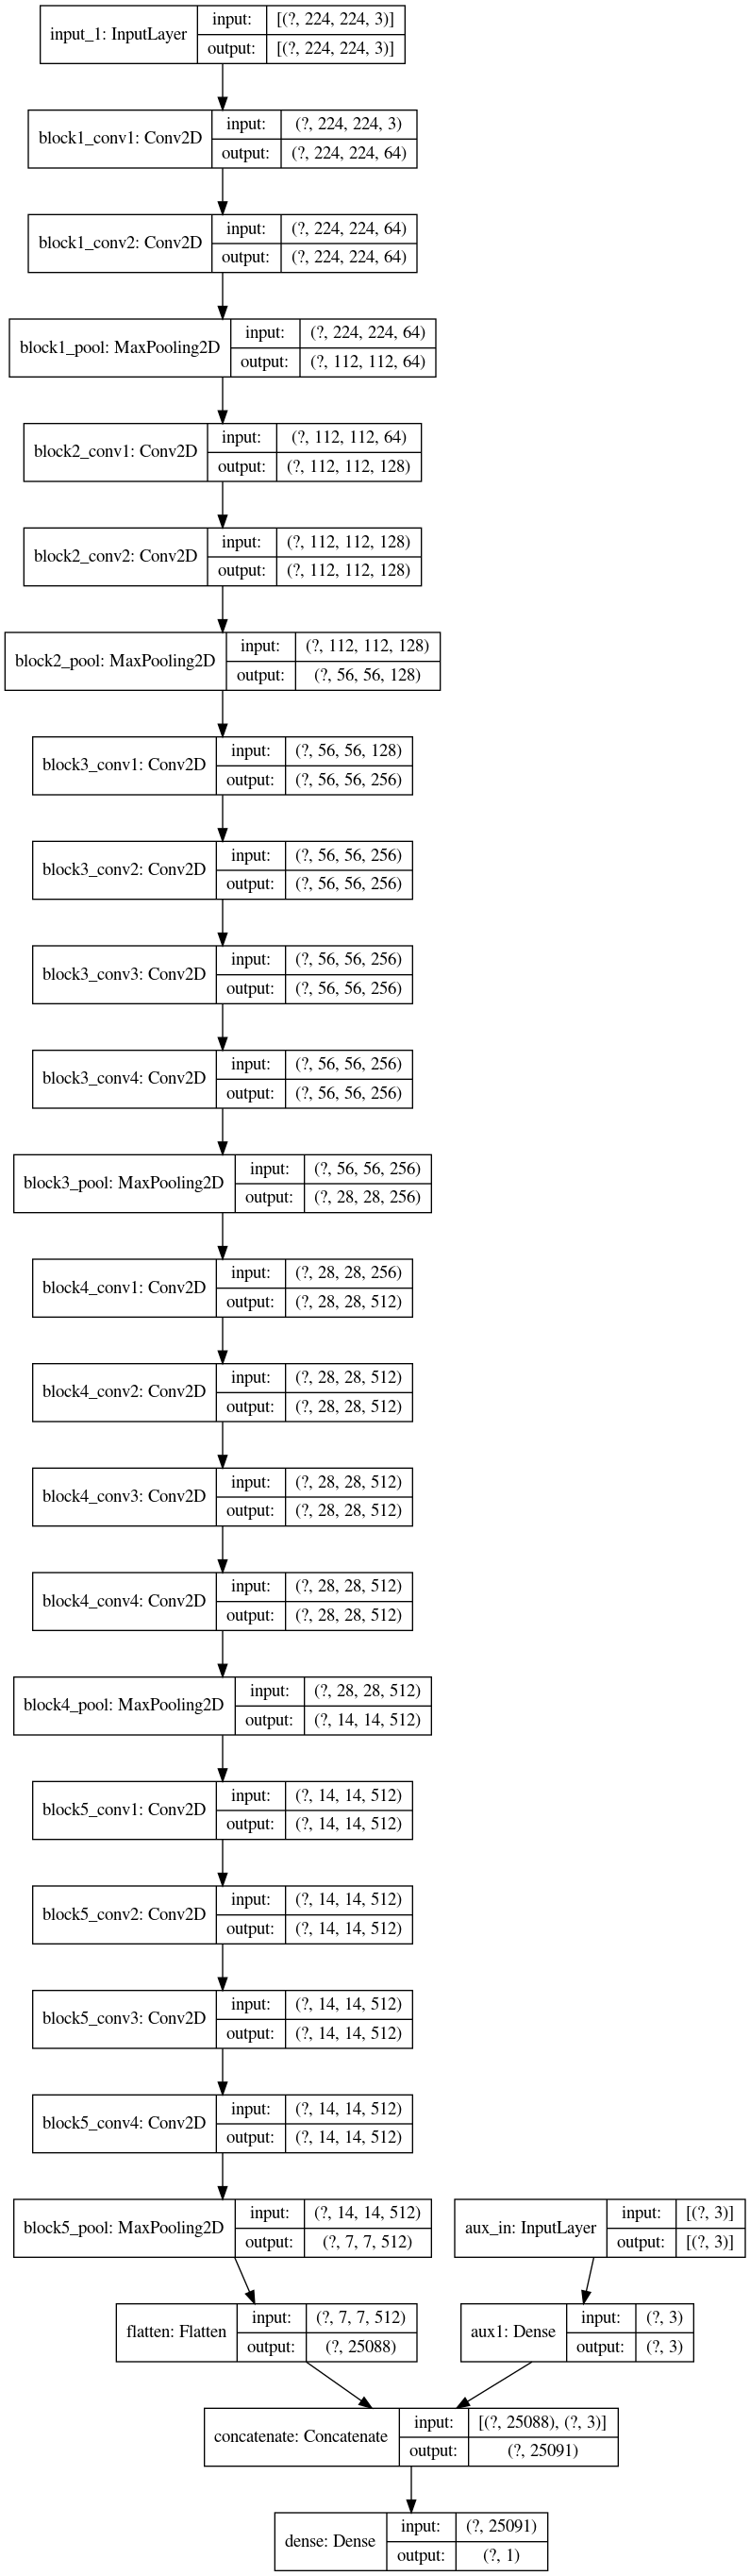

In [11]:
model = Model(inputs=[vgg.input, aux_in], outputs=[merged])
plot_model(model,to_file='demo.png',show_shapes=True)

Now we train using fit_generator, which feeds the model data in batches. The number of batches is steps_per_epoch, and since we only want to iterate through the data once, I set the steps per epoch to the (number of images)/batch size (in this case, 8). Note that the custom_gen is used twice--once for training data and once for validation data.

In [12]:
model.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()], optimizer=optimizer)

history = model.fit_generator(custom_gen(
    images = trainX,
    auxs = aux_trainX,
    labels = trainY,
    batch_size=8,
    val=False),
    steps_per_epoch = trainX.shape[0] // 8,
    epochs = 2, 
    validation_data = custom_gen(
    images = valX,
    auxs = aux_valX,
    labels = valY,
    batch_size=8,
    val=True),
    validation_steps = valX.shape[0] // 8
)

model.save('melanoma-classification-model-aux.h5')

Epoch 1/2
258/258 [==============================] - 27s 104ms/step - loss: 0.1138 - auc: 0.6670 - val_loss: 0.0483 - val_auc: 0.7839
Epoch 2/2
258/258 [==============================] - 26s 102ms/step - loss: 0.0415 - auc: 0.8445 - val_loss: 0.0471 - val_auc: 0.7953


In [13]:
del trainX, trainY, aux_trainX, aux_valX, valX, valY
gc.collect()

4880

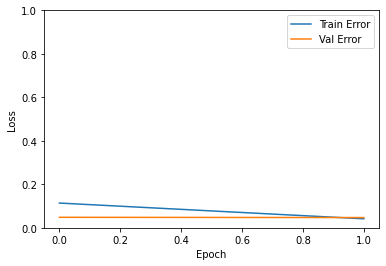

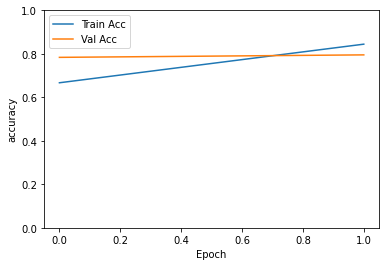

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label='Train Error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
plt.ylim([0, 1])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(hist['epoch'], hist['auc'], label='Train Acc') #if the model is initialized multiple times, keras makes a new AUC object. 
plt.plot(hist['epoch'], hist['val_auc'], label='Val Acc') #Copy the auc_x number shown in the terminal above.
plt.ylim([0, 1])
plt.legend()
plt.show()

Now we start the predictions process.

In [15]:
testing = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
testing.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [17]:
test_images = np.load('../input/siimisic-melanoma-resized-images/x_test_224.npy')
predictions = []
t_auxs = []

for img, sex, age in tqdm(zip(test_images, testing["sex"], testing["age_approx"])):
    img=np.reshape(img,(1,224,224,3))
    aux = [0,0,0]
    if (sex == "male"):
        aux[0] = 1
    else:
        aux[1] = 1
    aux[2] = (age-15)/75 #max age is 90, min age is 15           
    t_auxs.append(aux)
    aux = np.reshape(np.array(aux), (1,3)) 
    pred=model.predict([img, aux])
    predictions.append(pred[0][0])
    
t_auxs = np.array(t_auxs)
print(t_auxs.shape)

10982it [06:27, 28.34it/s]

(10982, 3)


Save for future reference.

In [18]:
with open("t_aux.npz", "wb") as file:
    np.savez_compressed(file, aux=t_auxs)

Check the predictions.

In [19]:
print(predictions[:10])

[0.5532716, 0.120398745, 0.062365197, 0.08152034, 0.17561658, 0.20044664, 0.25435707, 0.35178414, 0.15714413, 0.3290942]


Save.

In [22]:
results = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
results['target'] = predictions
results.to_csv('vgg_predictions5.csv', header=True, index=False)

In [23]:
results.head()

,image_name,target
0,ISIC_0052060,0.553272
1,ISIC_0052349,0.120399
2,ISIC_0058510,0.062365
3,ISIC_0073313,0.081520
4,ISIC_0073502,0.175617
